# Interpretability

- Data load and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error

In [2]:
#de mateo
#de mateo
#de mateo
dfFeature = pd.read_csv(r'pruebaData.csv')
dfFeature.drop(columns=['Complain'], inplace= True)

X = dfFeature.drop('Exited', axis=1)
y = dfFeature['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

INTRINSICALLY INTERPRETABLE MODELS:

First, we are going to analyze the interpretability of some classification models we have used, which are Logistic Regression and Decision Trees. The objective is to determine which of the variables have more impact in the outcome 

- Logistic Regression

- Logistic Regression

In [3]:
#de mateo
#de mateo
#de mateo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga","sag"])
    C = trial.suggest_float("C", 1e-6, 1e2, log =True)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=42,
        class_weight='balanced',
        max_iter= max_iter
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

logisticStudy = optuna.create_study(direction='maximize')
logisticStudy.optimize(objective,n_trials=500, n_jobs=-1)
print("Best hyperparameters:", logisticStudy.best_params)

[I 2024-12-22 12:50:40,706] A new study created in memory with name: no-name-32e92a45-5fea-4007-9cca-cb1167f37284
[I 2024-12-22 12:50:42,755] Trial 11 finished with value: 0.7961056909786095 and parameters: {'solver': 'liblinear', 'C': 19.557742129988988, 'max_iter': 693}. Best is trial 11 with value: 0.7961056909786095.
[I 2024-12-22 12:50:42,829] Trial 7 finished with value: 0.792542208011095 and parameters: {'solver': 'sag', 'C': 0.0001948237964247738, 'max_iter': 4899}. Best is trial 11 with value: 0.7961056909786095.
[I 2024-12-22 12:50:42,854] Trial 1 finished with value: 0.7961032832198477 and parameters: {'solver': 'saga', 'C': 29.87887114210753, 'max_iter': 3096}. Best is trial 11 with value: 0.7961056909786095.
[I 2024-12-22 12:50:42,867] Trial 0 finished with value: 0.7889238281438106 and parameters: {'solver': 'liblinear', 'C': 1.5144020219385163e-05, 'max_iter': 4362}. Best is trial 11 with value: 0.7961056909786095.
[I 2024-12-22 12:50:42,983] Trial 5 finished with value:

Best hyperparameters: {'solver': 'saga', 'C': 0.04500851893502781, 'max_iter': 494}


In [4]:
best_params = logisticStudy.best_params
logistic_model = LogisticRegression(
    solver=best_params["solver"],
    C=best_params["C"],
    random_state=42,
    class_weight='balanced',
    max_iter=best_params["max_iter"]
)

logistic_model.fit(X_train_scaled, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logistic_score = cross_val_score(logistic_model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(logistic_score)

0.7961437335670464


In [5]:
coefs_log = logistic_model.coef_
intercept_log = logistic_model.intercept_
print('coefficients: %s' % coefs_log)
print('intercept: %s' % intercept_log)

coefficients: [[-0.07078167 -0.01185399  0.07119704 -0.42782759 -0.01853448 -0.41113375
   0.0385659  -0.01583279 -0.05132585  0.1437617  -0.1437617  -0.14630018
   0.26157737 -0.09328202  0.03098611 -0.02272395 -0.00612744 -0.00189091
  -0.29957058  0.26890995  0.47809699 -0.37376367  0.15467218]]
intercept: [-0.37897895]


In [6]:
# Feature Importance
coef_df = pd.DataFrame({'feature': X_train.columns.values, 'coef': coefs_log[0]})
coef_df

,feature,coef
0,CreditScore,-0.070782
1,Tenure,-0.011854
2,Balance,0.071197
3,NumOfProducts,-0.427828
4,HasCrCard,-0.018534
5,IsActiveMember,-0.411134
6,EstimatedSalary,0.038566
7,Satisfaction Score,-0.015833
8,Point Earned,-0.051326
9,Gender_Female,0.143762


In [7]:
#Standardized
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(23,) * stdv).sort_values(ascending=False)

Balance               4435.881006
EstimatedSalary       2214.650057
Point Earned            11.602786
CreditScore              6.843884
NumOfProducts            0.213885
IsActiveMember           0.205453
Age_30-40                0.148587
Age_<30                  0.138692
Age_50-60                0.134832
Age_40-50                0.117564
Geography_Germany        0.113454
Geography_France         0.073150
Gender_Female            0.071540
Gender_Male              0.071540
Geography_Spain          0.040304
Age_>60                  0.034882
Tenure                   0.034261
Satisfaction Score       0.022329
Card Type_DIAMOND        0.013370
Card Type_GOLD           0.009901
HasCrCard                0.008432
Card Type_PLATINUM       0.002652
Card Type_SILVER         0.000817
dtype: float64

- Decision Tree

In [8]:
#de mateo
#de mateo
#de mateo
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight="balanced", 
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_params)

[I 2024-12-22 12:51:10,630] A new study created in memory with name: no-name-8768eaa6-66da-4e84-be8f-998016259465
[I 2024-12-22 12:51:10,801] Trial 2 finished with value: 0.769461432520153 and parameters: {'n_estimators': 573, 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 2 with value: 0.769461432520153.
[I 2024-12-22 12:51:10,880] Trial 0 finished with value: 0.7773937937610155 and parameters: {'n_estimators': 852, 'max_depth': 8, 'min_samples_split': 30, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7773937937610155.
[I 2024-12-22 12:51:10,894] Trial 3 finished with value: 0.767060415482852 and parameters: {'n_estimators': 213, 'max_depth': 40, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7773937937610155.
[I 2024-12-22 12:51:10,925] Trial 1 finished with value: 0.6591273319143608 and parameters: {'n_estimators': 899, 'max_depth': 20, 

Best hyperparameters: {'n_estimators': 992, 'max_depth': 7, 'min_samples_split': 28, 'min_samples_leaf': 13, 'max_features': None}


In [ ]:
best_params = treeStudy.best_params
decision_tree = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    class_weight="balanced",
)
decision_tree.fit(X_train, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
decision_score = cross_val_score(decision_tree, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(decision_score)   

0.7860785796149512


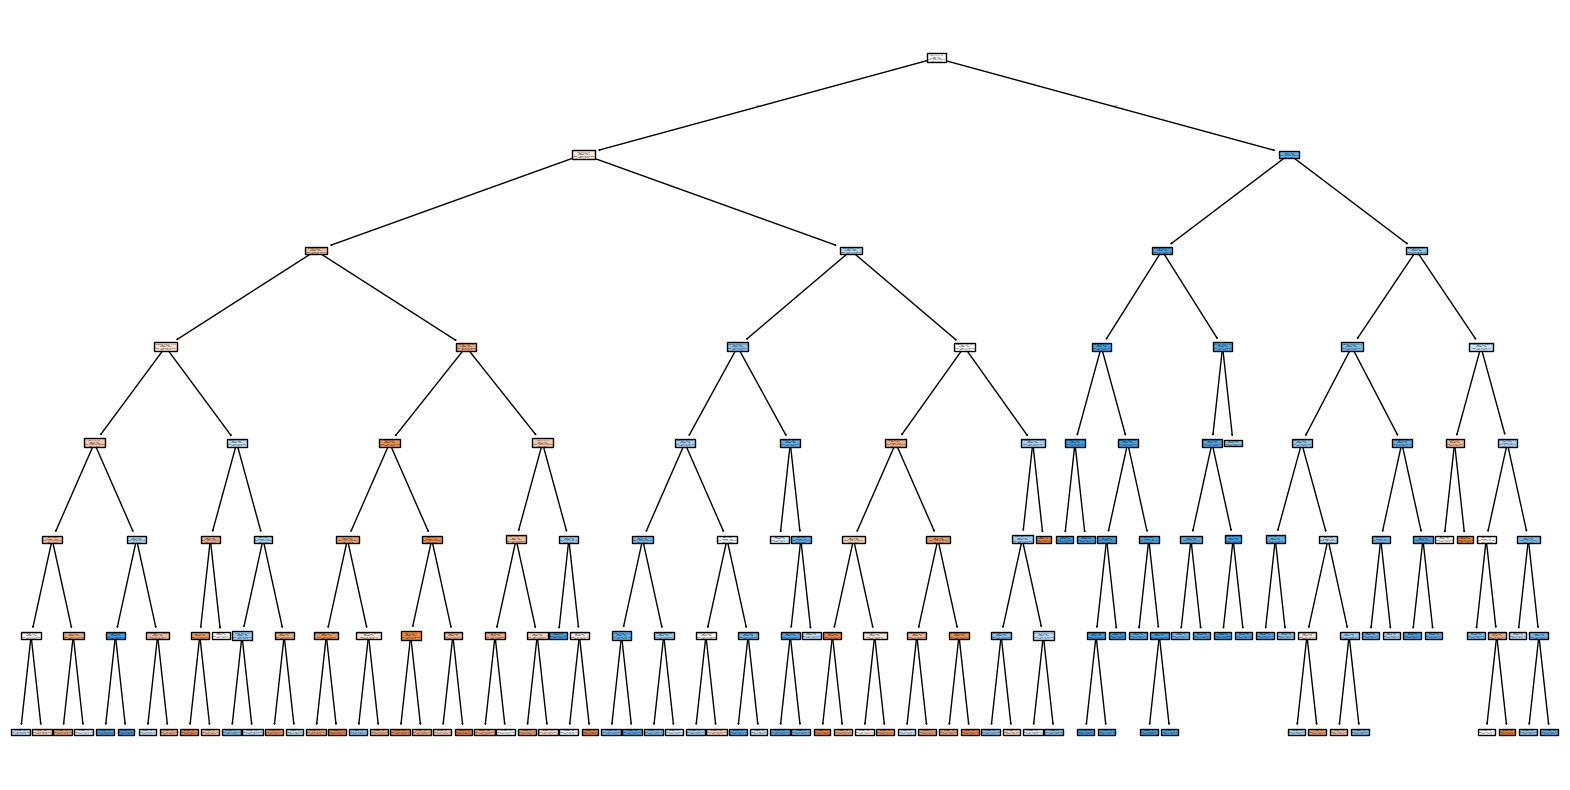

In [10]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'])
plt.show()

In [11]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),
'importance': decision_tree.feature_importances_}).sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
20,Age_50-60,0.206286
2,Balance,0.198610
19,Age_40-50,0.189295
3,NumOfProducts,0.107179
5,IsActiveMember,0.069589
12,Geography_Germany,0.058027
22,Age_>60,0.044242
0,CreditScore,0.033833
6,EstimatedSalary,0.032525
1,Tenure,0.016660


Now we will interprate the results given by both models:

    Logistic Regression:

 -Most possitively influential variables:  'Age_50-60' (0.47), 'Age_40-50' (0.26) and 'Geography_Germany' (0.26)

 -Most negatively influential variables: NumOfProducts (-0.42), 'IsActiveMember'(-0.41) and 'Age_<30' (-0.37)

 -Most influential standardized variables: 'Balance' (4435.93) and 'EstimatedSalary' (2214.62)

The logistic regression model (79.61%) indicates that age and geography, as well as the balance and the estimated salary are really important for the model's predictions.

We can see that age categories follow a clear pattern, the old customers with higher balance, have the highest chance to exit on the outcome, while the young and inactive customer is the least likely to exit.

Also, If we compare 'Gender_Female' (0.14) and 'Gender_Male' (-0.14), we can se that male customers have a negative influence and females are possitively influential in this case, showing that females are more likely to exit and males to stay. Also, German people seem to be specially predisposed to exiting banks. 

The negative intercept (-0.37) means that if there is no influence, customers are less likely to exit. But this is not relevant in out case because variables like age are practically never 0.

    Decision Tree

The decision tree model (78.91%) suggests that it's most important features are 'Age_50-60' (0.22), 'Balance' (0.19), 'Age_40-50' (0.19) and 'NumOfProducts' (0.10). The rest have low or 0 relevance. In conclussion, the decision tree model supports our logistic regression model's conclussions which are the most important factors.

GLOBAL MODEL AGNOSTIC METHODS

The second step is to understand which is the way our models work, for that we are going to use PDP and ALE:

- Partial Dependence Plot (PDP)

For this section, we are going to apply PDP to the most influential variables of the decision tree model

c:\Users\dekum\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dekum\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dekum\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dekum\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dekum\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.w

Text(0.5, 0.98, 'Partial Dependence Plots - Decision Tree')

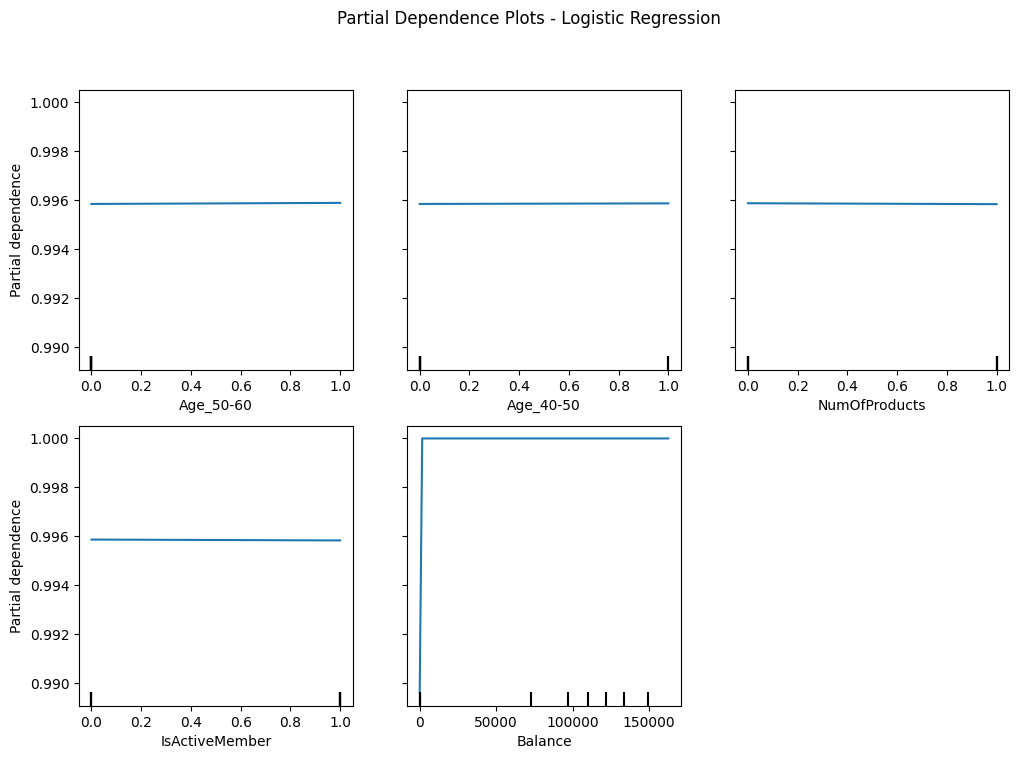

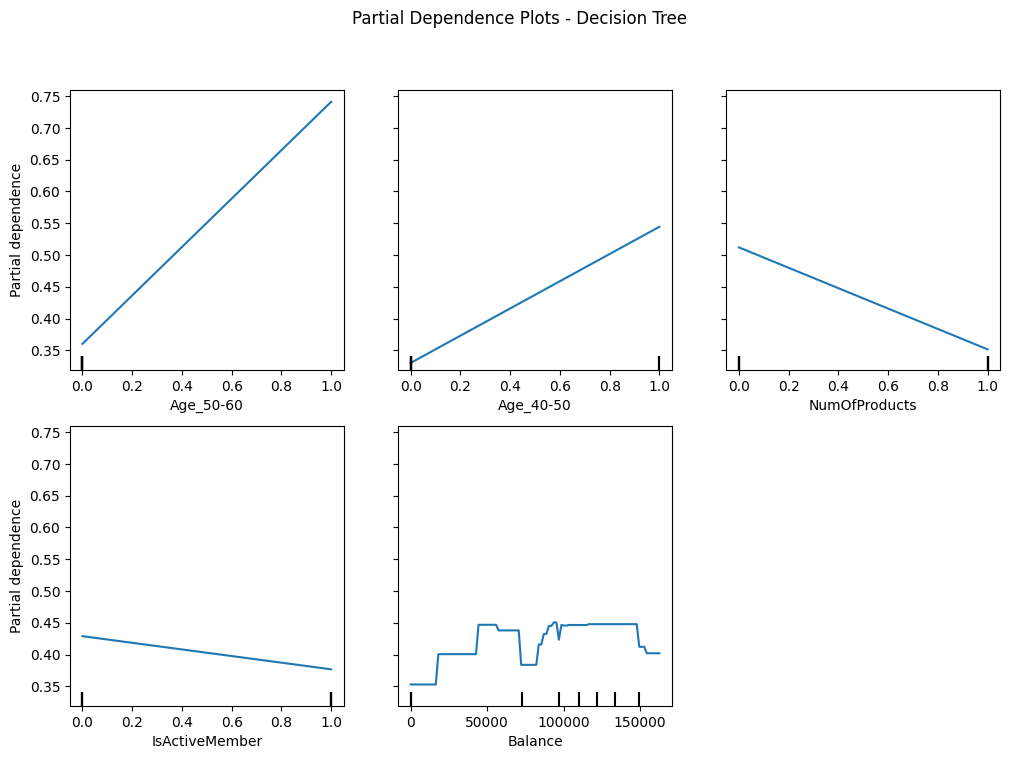

In [17]:
features = ["Age_50-60", "Age_40-50","NumOfProducts", "IsActiveMember", "Balance"]


fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(logistic_model, X_train, features, kind="average", ax=ax)
display.figure_.suptitle("Partial Dependence Plots - Logistic Regression")

fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(decision_tree, X_train, features, kind="average", ax=ax)
display.figure_.suptitle("Partial Dependence Plots - Decision Tree")

- Accumulated Local Effects (ALE)

In [ ]:
from alibi.explainers import ALE, plot_ale
import numpy as np

features = ['Age_50-60', 'Balance', 'Age_40-50', 'NumOfProducts', 'IsActiveMember', 
            'Geography_Germany', 'Age_>60', 'CreditScore', 'EstimatedSalary', 'Tenure', 
            'Gender_Male', 'Point Earned', 'Gender_Female', 'Satisfaction Score', 
            'Card Type_DIAMOND', 'Card Type_GOLD', 'HasCrCard', 'Geography_Spain', 
            'Geography_France', 'Age_30-40', 'Card Type_SILVER', 'Card Type_PLATINUM', 'Age_<30']
#Logistic regression
X_train_np = X_train[features].to_numpy().astype(float)
logisticALE = ALE(logistic_model.predict, feature_names=features)
logisticExp = logisticALE.explain(X_train_np)
# Plot ALEs
plot_ale(logisticExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 14})
logisticMSE = mean_squared_error(y_test, logistic_model.predict(X_test))
print(f"Logistic Regression MSE: {logisticMSE}")
#Decision Tree
X_train_np = X_train[features].to_numpy().astype(float)
dTreeALE = ALE(decision_tree.predict, feature_names=features)
dTreeExp = dTreeALE.explain(X_train_np)
# Plot ALEs
plot_ale(dTreeExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 14})
dTreeMSE = mean_squared_error(y_test, decision_tree.predict(X_test))
print(f"Logistic Regression MSE: {dTreeMSE}")

IMPORTANT: We tried to use alibi for this, but as it uses obsolete versions of diferent python libraries, we ended up not being able to run other methods because of that. To fix it, we have decided to run the same code in google collab, so the image below is the result. We are sorry for the inconvenience but this is the best solution we have found. So we just want to explain that the code works fine, the issue is the alibi library.

Logistic Regression MSE: 0.7885

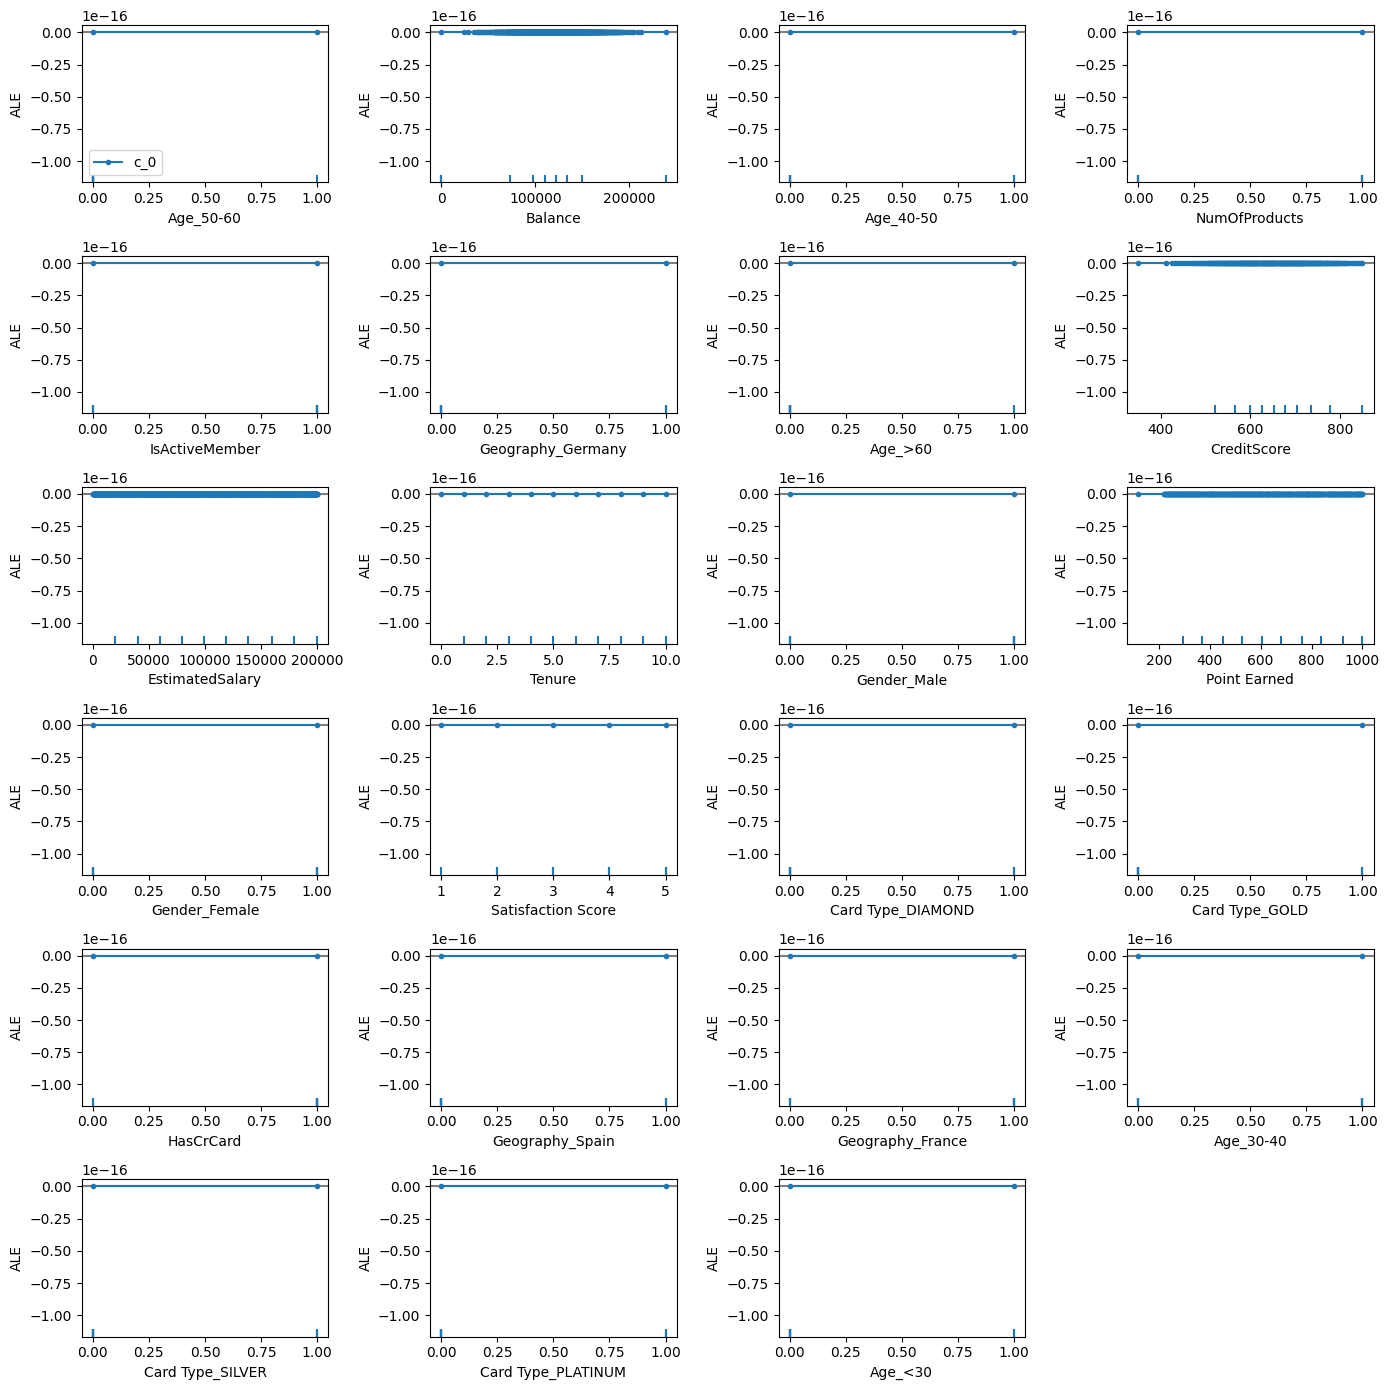

Decision Tree MSE: 0.2565

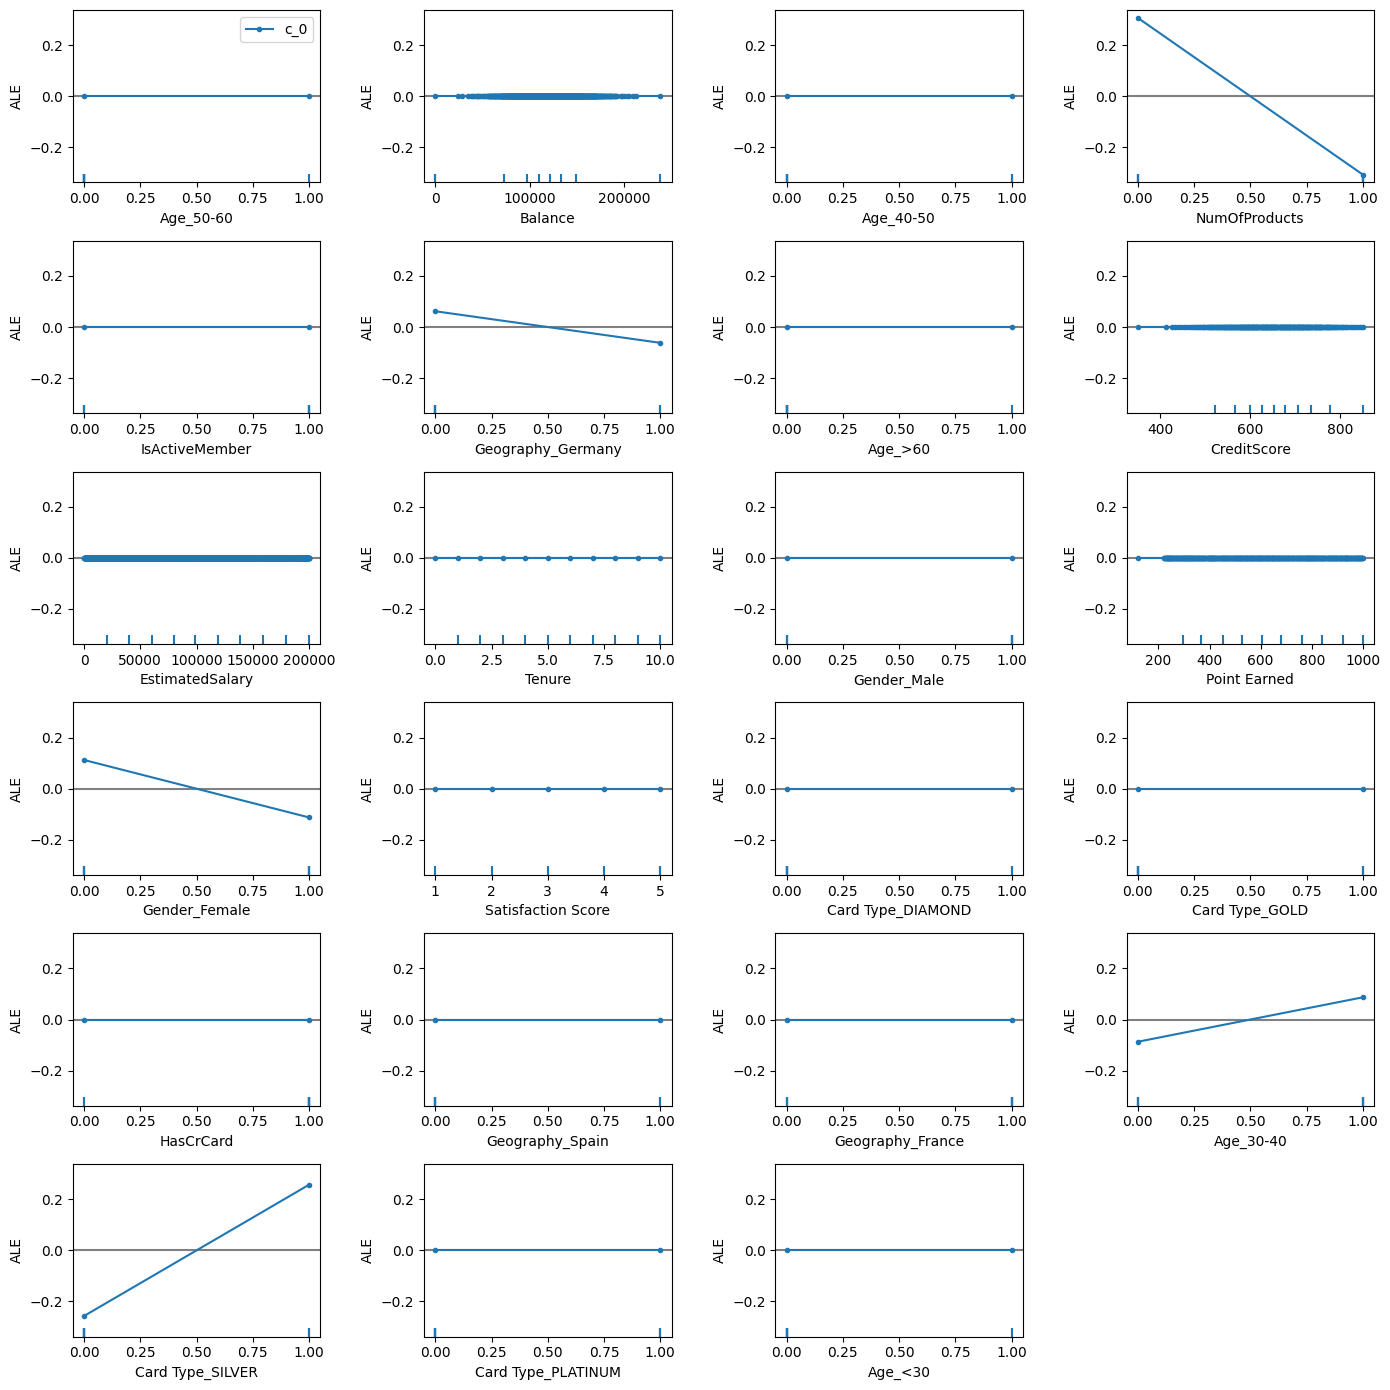

    PDP

The result suggests that firstly, for both 'Age_50-60' and 'Age_40-50', as the value increases (it can only be 0 or 1), the chances of exit prediction also increases, although its less pronounced for the 40-50 age varaible, the effects is really similar. Also, it seems like the 'NumOfProducts' variable has almost the contrary effect on the model if we compare it with 'Age_40-50', and much the same happens with 'isActiveMember', but less strongly.  

Secondly, the relation between the 'Balance' variable's value, and the changes of exit prediction change, not as in the previous case. So, as well as we know that this variable is really important for the model's predictions, now we know that the way this variable is considered for the model's prediction is not linear, as we could have guessed → (Higher balance → + chances of exit).

    ALE

Across both logistic regression and decision tree models, the ALE method shows that almost no variables have low or no impact on the prediction, but what we can say is that 'age_30-40' and 'CardType_SILVER' have a possitive impact for the decision tree prediction, which hasn't been as clear or relevant as other age groups have been up to this moment, but in this case they can be considerent as the two only variables with any effect in the model. Also, the decision tree shows a clear negative influence of 'NumOfProducts', which supports our previous conclussions.

Overall, we can see that PDP supports the conclussions we have made for the 'intrinsically interpretable model' step's results, but also, giving some really interesting insights, on how each of the most important variables in the model affect the prediction. In the ALE case, the results dont meet with what we have seen overall, so ALE may not be the best way to interpret our case.



LOCAL MODEL AGNOSTIC METHODS

This sections requires the use of SHAP, and we will use it random forest regression

- Random Forest Regression

In [28]:
#NO ES DE MATEO
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="neg_mean_squared_error", n_jobs=-1).mean() 
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_params)

[I 2024-12-22 15:45:05,787] A new study created in memory with name: no-name-d02587cb-8ae2-4dce-9e16-1f4607d1092e
[I 2024-12-22 15:45:07,503] Trial 3 finished with value: -0.1299668406112277 and parameters: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 3 with value: -0.1299668406112277.
[I 2024-12-22 15:45:11,103] Trial 0 finished with value: -0.12631769711568722 and parameters: {'n_estimators': 417, 'max_depth': 35, 'min_samples_split': 15, 'min_samples_leaf': 32, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.12631769711568722.
[I 2024-12-22 15:45:13,502] Trial 1 finished with value: -0.12313923738157621 and parameters: {'n_estimators': 959, 'max_depth': 43, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.12313923738157621.
[I 2024-12-22 15:45:15,031] Trial 2 finished with value: -0.12492376490022335 and parameters: {'n_estimators': 540, 'ma

Best hyperparameters: {'n_estimators': 998, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 22, 'max_features': None}


In [32]:
from sklearn.metrics import mean_absolute_error

best_params = rdForestStudy.best_params
randomForestReg = RandomForestRegressor(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
)
randomForestReg.fit(X_train, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
forest_score = cross_val_score(randomForestReg, X_train, y_train, cv=skf,scoring="neg_mean_squared_error", n_jobs=-1).mean() 
print(forest_score) 
   
y_pred = randomForestReg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', round(mae, 2))


-0.12064380982261916
MAE: 0.24


IMPORTANT: Here we cant use shap because the latest accepted version of python is 3.9, but we are at 3.13.1, so we will have to run it on google collab, so the image and text below are the result of the code. Again, we are sorry for the inconvenience.

In [ ]:
#import shap
#explainer = shap.Explainer(randomForest, X_train)
#shap_values = explainer(X_test)

 98%|===================| 1969/2000 [00:37<00:00]  

In [ ]:
#shap.plots.waterfall(shap_values[0], max_display=23)

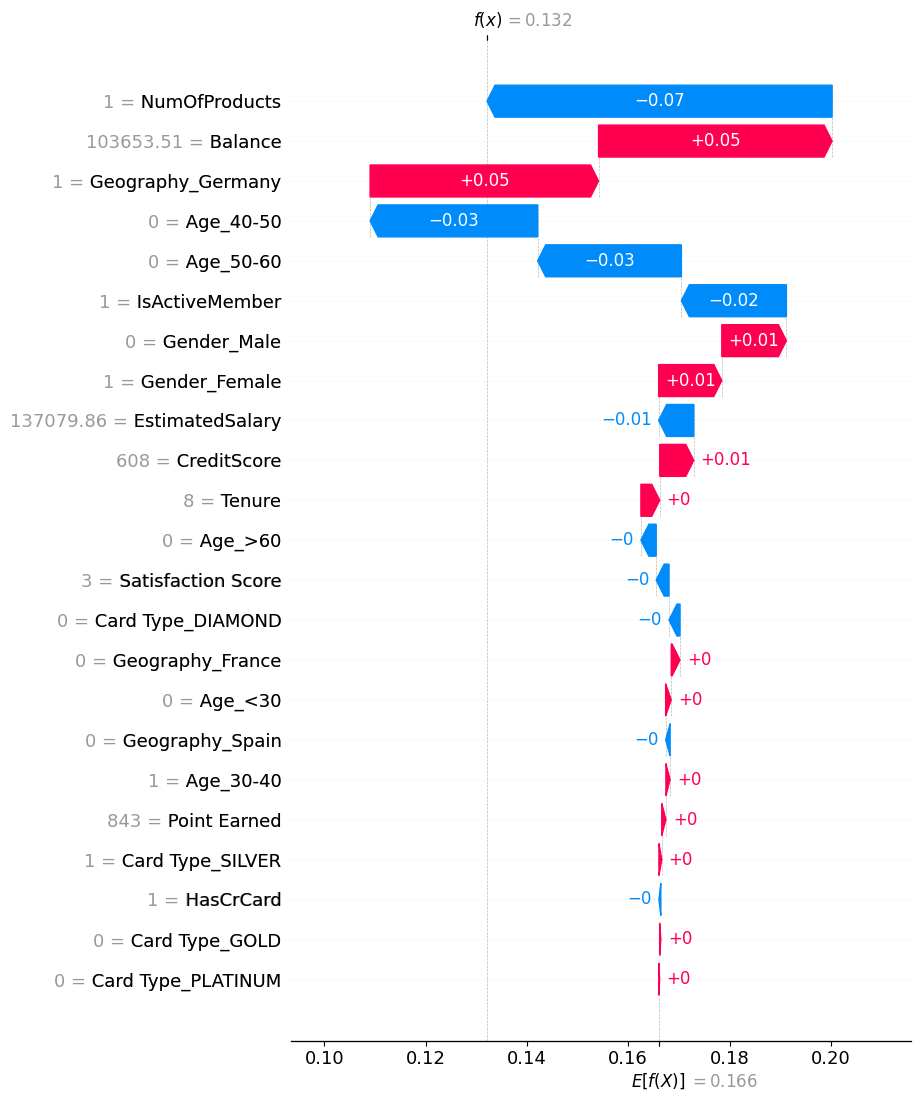

In [ ]:
#shap.plots.bar(shap_values)

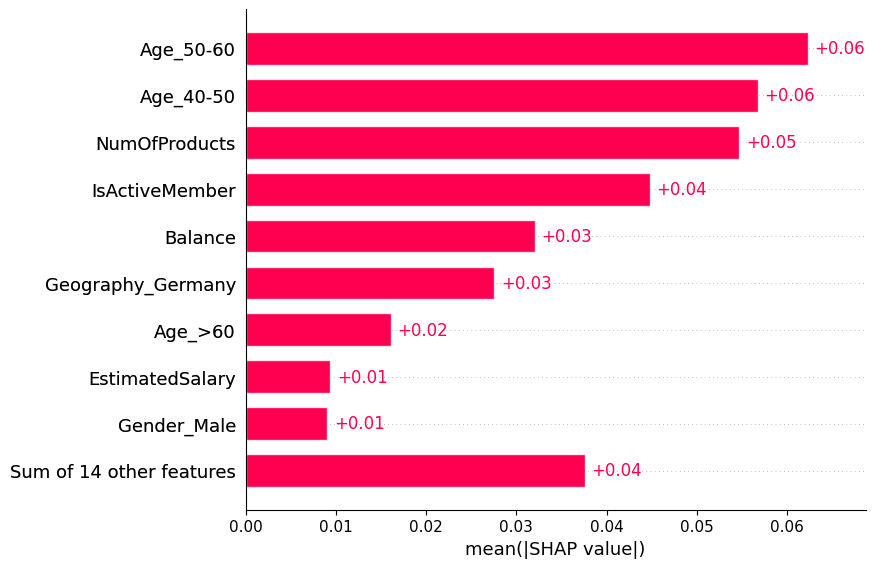

In [ ]:
#shap.initjs()
#shap.plots.force(shap_values[1])

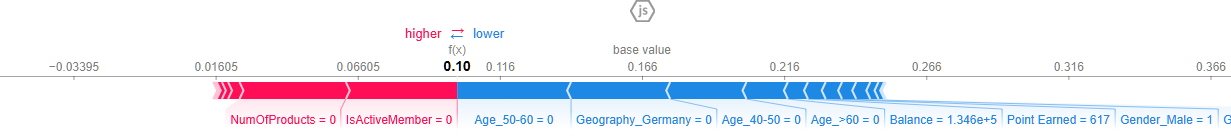

From the SHAP results, we can guess some general ideas: First, the variables that affect more the model when they have certain values are: (The 1st value is the value at which the variable affects the model, and the 2nd is the contribution value)

Negatively: 'NumOfColumns'(1)  (-0.7), 'Age_40-50' (0) (-0.03), 'Age_50-60'(0) (-0.03), 'IsActiveMember' (1) (-0.02)

Positively: 'Geography_Germany' (1) (0.05), 'Balance' (103653.51) (0.05), 'Gender_Male' (0) (0.01), 'Gender_Female' (1) (-0.01)   

These SHAP results, overall, are pretty similar to the ones that have gotten before with different classification models, suggesting that SHAP supports the results we have made until this moment. Also, SHAP maker a new little contribution of suggesting that, when the estimated salary is high (138089.86), the model takes it as a possible reason for staying, although, its contribution value (-0.01) is not as strong as the rest of the variables, the ones we already new that are really important for the model general conclusions, so even if its a new contribution for us, its not relevant enough for us to take it into consideration in the general case.     